In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from parse_utils import parse_benchmark_results
from utils import abs_listdir
csv_results = abs_listdir('csv/first_parsed')

In [3]:
csv_results

['/home/sobir/Desktop/dsproject/csv/first_parsed/tanh_depthwise.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/tanh.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/relu.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/elu_spatial.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/relu_depthwise.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/relu_depthwise_spatial.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/elu_depthwise.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/relu_spatial.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/elu_depthwise_spatial.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/tanh_spatial.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/tanh_depthwise_spatial.csv',
 '/home/sobir/Desktop/dsproject/csv/first_parsed/elu.csv']

In [14]:
df = pd.read_csv(csv_results[1])
df

,node type,start,first,avg_ms,%,cdf%,mem KB,times called,name
0,CONV_2D,0.000000,0.123,0.076081,45.4798%,45.4798%,0,1,[sequential_21/conv2d_63/Conv2D]:0
1,TANH,0.076320,0.010,0.009128,5.45632%,50.9361%,0,1,[sequential_21/conv2d_63/Tanh]:1
2,AVERAGE_POOL_2D,0.085635,0.026,0.024669,14.7466%,65.6827%,0,1,[sequential_21/average_pooling2d_42/AvgPool]:2
3,CONV_2D,0.110490,0.034,0.025475,15.2285%,80.9113%,0,1,[sequential_21/conv2d_64/Conv2D]:3
4,TANH,0.136180,0.004,0.003389,2.02603%,82.9373%,0,1,[sequential_21/conv2d_64/Tanh]:4
5,AVERAGE_POOL_2D,0.139750,0.004,0.003677,2.19807%,85.1354%,0,1,[sequential_21/average_pooling2d_43/AvgPool]:5
6,CONV_2D,0.143614,0.020,0.019016,11.3675%,96.5029%,0,1,[sequential_21/conv2d_65/Conv2D]:6
7,TANH,0.162841,0.001,0.000528,0.315897%,96.8188%,0,1,[sequential_21/conv2d_65/Tanh]:7
8,FULLY_CONNECTED,0.163552,0.004,0.003606,2.15558%,98.9744%,0,1,[sequential_21/dense_42/MatMul]:8
9,TANH,0.167341,0.000,0.000417,0.249195%,99.2236%,0,1,[sequential_21/dense_42/Tanh]:9


In [5]:
dfs = {os.path.split(r)[1] : pd.read_csv(r) for r in csv_results}
conv_time_total = {}
conv_percentage_total = {}
conv_type = {}
activation_time_total = {}
activation_percentage_total = {}
activation = {}


for filename, df in dfs.items():
    # convolution statistics
    df_convs = df[df['node type'].apply(lambda s: 'CONV' in s)]
    conv_time_total[filename] = df_convs[' avg_ms'].sum()
    conv_percentage_total[filename] = df_convs[' %'].apply(lambda s: float(s[:-1])).sum()
    conv_type[filename] = '_'.join(filename.split('_')[1:]) or 'regular'
    
    # activation statistics
    df_activations = df[df['node type'].apply(lambda s: s in ['ELU', 'RELU', 'TANH'])]
    activation_time_total[filename] = df_activations[' avg_ms'].sum()
    activation_percentage_total[filename] = df_activations[' %'].apply(lambda s: float(s[:-1])).sum()
    # exclude extension from filename
    fname = filename[:filename.index('.')]
    activation[filename] = fname.split('_', maxsplit=1)[0].upper()
    

result = pd.DataFrame({'conv_type': conv_type,
                       'conv_time_total': conv_time_total, 
                       'conv_percentage_total': conv_percentage_total,
                       'activation': activation,
                       'activation_time_total': activation_time_total,
                       'activation_percentage_total': activation_percentage_total})
result.sort_index(inplace=True)
result

,conv_type,conv_time_total,conv_percentage_total,activation,activation_time_total,activation_percentage_total
elu.csv,regular,0.124905,58.082150,ELU,0.054706,25.438991
elu_depthwise.csv,depthwise.csv,0.093806,50.655639,ELU,0.055365,29.897584
elu_depthwise_spatial.csv,depthwise_spatial.csv,0.087502,50.493786,ELU,0.051195,29.542694
elu_spatial.csv,spatial.csv,0.109394,51.538378,ELU,0.062501,29.445592
relu.csv,regular,0.118529,77.575000,RELU,0.000000,0.000000
relu_depthwise.csv,depthwise.csv,0.068489,66.846065,RELU,0.000000,0.000000
relu_depthwise_spatial.csv,depthwise_spatial.csv,0.101560,73.365681,RELU,0.000000,0.000000
relu_spatial.csv,spatial.csv,0.083285,71.644611,RELU,0.000000,0.000000
tanh.csv,regular,0.120572,72.075800,TANH,0.013462,8.047442
tanh_depthwise.csv,depthwise.csv,0.074961,61.490358,TANH,0.013074,10.724969


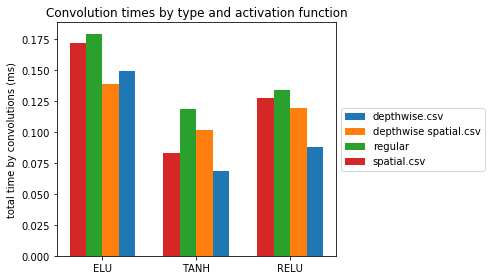

In [15]:
labels = ['ELU', 'TANH', 'RELU']
conv_types = result['conv_type'].unique()
# sort for consistent order
conv_types.sort()

x = np.arange(len(labels)) * 2  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = {}
mid_padding = 0.0
for i, conv_type in enumerate(conv_types):
    pos = x - ((i-2)*(1+mid_padding) + 1/2) * width
    r = result[result['conv_type'] == conv_type]
    label = conv_type.replace('_', ' ')
    rects[conv_type] = ax.bar(pos, r['conv_time_total'] + r['activation_time_total'], width, label=label)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('total time by convolutions (ms)')
ax.set_title('Convolution times by type and activation function')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()
plt.show()

Text(0, 0.5, 'total time (ms)')

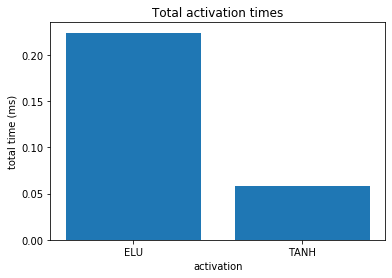

In [11]:
# plot average exec time for each activation operations ELU, TANH
means = result.groupby('activation').agg('sum')
# drop relu because it is zero
means.drop('RELU', inplace=True)
plt.bar(means.index, means['activation_time_total'])
plt.title('Total activation times')
plt.xlabel('activation')
plt.ylabel('total time (ms)')

,conv_time_total,conv_percentage_total,activation_time_total,activation_percentage_total
activation,,,,
ELU,0.415607,210.769953,0.223767,114.324861
TANH,0.410499,265.977282,0.058434,38.439782
